In [ ]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary
import pickle
from sklearn.metrics import classification_report
from PIL import Image
from tqdm.auto import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
import time
import os
!pip install onnx onnxscript
!pip install torchsummary onnx onnxruntime
%matplotlib inline


## Определяем видеокарту GPU, чтобы на ней учить нейронную сеть

In [ ]:
!nvidia-smi
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используется устройство: {device}")

Thu Dec 25 21:08:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   77C    P0             34W /   70W |    1478MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Загрузка и распаковка набора данных CIFAR100

In [ ]:
# Загрузка данных
!wget -q https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
!tar -xzf cifar-100-python.tar.gz

## Чтение тренировочной и тестовой выборки

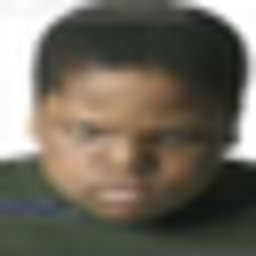

In [ ]:
with open('cifar-100-python/train', 'rb') as f:
    data_train = pickle.load(f, encoding='latin1')
with open('cifar-100-python/test', 'rb') as f:
    data_test = pickle.load(f, encoding='latin1')

# Здесь указать ваши классы по варианту!!!
CLASSES = [22, 11]

train_X = data_train['data'].reshape(-1, 3, 32, 32)
train_X = np.transpose(train_X, [0, 2, 3, 1]) # NCWC -> NWHC
train_y = np.array(data_train['fine_labels'])
mask = np.isin(train_y, CLASSES)
train_X = train_X[mask].copy()
train_y = train_y[mask].copy()
train_y = np.unique(train_y, return_inverse=1)[1]
del data_train

test_X = data_test['data'].reshape(-1, 3, 32, 32)
test_X = np.transpose(test_X, [0, 2, 3, 1])
test_y = np.array(data_test['fine_labels'])
mask = np.isin(test_y, CLASSES)
test_X = test_X[mask].copy()
test_y = test_y[mask].copy()
test_y = np.unique(test_y, return_inverse=1)[1]
del data_test
Image.fromarray(train_X[50]).resize((256,256))

## Создание Pytorch DataLoader'a

In [ ]:
batch_size = 128
dataloader = {}

for (X, y), part in zip([(train_X, train_y), (test_X, test_y)], ['train', 'test']):
    tensor_x = torch.Tensor(X)
    tensor_y = F.one_hot(torch.Tensor(y).to(torch.int64),
                         num_classes=len(CLASSES)).float()
    dataset = TensorDataset(tensor_x, tensor_y)
    dataloader[part] = DataLoader(dataset, batch_size=batch_size, shuffle=(part == 'train'))

## ОПРЕДЕЛЕНИЕ МОДЕЛИ CNN С РАЗНЫМИ ТИПАМИ ПУЛЛИНГА

In [ ]:
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean).view(1, 1, 1, 3).to(device)
        self.std = torch.tensor(std).view(1, 1, 1, 3).to(device)

    def forward(self, input):
        x = input / 255.0
        x = (x - self.mean) / self.std
        return x.permute(0, 3, 1, 2)  # NHWC -> NCHW

class Cifar100_CNN(nn.Module):
    def __init__(self, hidden_size=32, num_classes=2, pooling_type='max'):
        super(Cifar100_CNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.pooling_type = pooling_type

        # Сверточные слои
        self.conv1 = nn.Conv2d(3, hidden_size, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(hidden_size)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(hidden_size, hidden_size*2, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(hidden_size*2)
        self.relu2 = nn.ReLU()

        # Пуллинг слой
        if pooling_type == 'stride':
            # Stride pooling через свертку с шагом
            self.pool = nn.Conv2d(hidden_size*2, hidden_size*2, kernel_size=3,
                                  stride=2, padding=1)
        elif pooling_type == 'max':
            self.pool = nn.MaxPool2d(2)
        elif pooling_type == 'avg':
            self.pool = nn.AvgPool2d(2)
        else:
            raise ValueError(f"Неизвестный тип пуллинга: {pooling_type}")

        # Дополнительные слои
        self.conv3 = nn.Conv2d(hidden_size*2, hidden_size*4, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(hidden_size*4)
        self.relu3 = nn.ReLU()

        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(hidden_size*4, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # Если вход в формате NHWC, преобразуем в NCHW
        if x.dim() == 4 and x.shape[-1] == 3:
            x = x.permute(0, 3, 1, 2)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        x = self.pool(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)

        return x


## ФУНКЦИИ ДЛЯ ОБУЧЕНИЯ И ОЦЕНКИ

In [ ]:
def train_model(model, dataloader, criterion, optimizer, num_epochs=50):
    """Обучение модели с возвратом метрик"""
    model.train()
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    best_val_acc = 0.0
    best_model_state = None

    for epoch in range(num_epochs):
        # Тренировка
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0

        for inputs, labels in dataloader['train']:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.argmax(dim=1) if labels.dim() > 1 else labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.argmax(dim=1)).item()
            total_samples += inputs.size(0)

        epoch_loss = running_loss / total_samples
        epoch_acc = running_corrects / total_samples
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)

        # Валидация
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in dataloader['test']:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels.argmax(dim=1))

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.argmax(dim=1)).item()
                val_total += inputs.size(0)

        val_epoch_loss = val_loss / val_total
        val_epoch_acc = val_corrects / val_total
        val_losses.append(val_epoch_loss)
        val_accs.append(val_epoch_acc)

        # Сохранение лучшей модели
        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            best_model_state = model.state_dict().copy()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}: '
                  f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, '
                  f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}')

    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'best_val_acc': best_val_acc,
        'best_model_state': best_model_state
    }

## ОБУЧЕНИЕ МОДЕЛЕЙ С РАЗНЫМИ ТИПАМИ ПУЛЛИНГА

In [ ]:
HIDDEN_SIZE = 64
EPOCHS = 50  # Уменьшено для быстрого обучения, можно увеличить для лучшей точности
LEARNING_RATE = 0.001

# Нормализация для CIFAR-100
normalize_layer = Normalize(
    mean=[0.5071, 0.4867, 0.4408],
    std=[0.2675, 0.2565, 0.2761]
)

results = {}
training_times = {}
models_dict = {}

# Типы пуллинга для сравнения
pooling_types = ['stride', 'max', 'avg']

for pooling_type in pooling_types:
    print(f"\n{'='*60}")
    print(f"Обучение модели с пуллингом типа: {pooling_type}")
    print(f"{'='*60}")

    # Создание модели
    model = Cifar100_CNN(
        hidden_size=HIDDEN_SIZE,
        num_classes=len(CLASSES),
        pooling_type=pooling_type
    )
    model = nn.Sequential(normalize_layer, model).to(device)

    # Критерий и оптимизатор
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

    # Обучение модели с замером времени
    start_time = time.time()

    metrics = train_model(
        model=model,
        dataloader=dataloader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=EPOCHS
    )

    end_time = time.time()
    training_time = end_time - start_time
    training_times[pooling_type] = training_time

    # Сохранение результатов
    results[pooling_type] = metrics
    models_dict[pooling_type] = model

    print(f"\nВремя обучения: {training_time:.2f} секунд")
    print(f"Лучшая точность на валидации: {metrics['best_val_acc']:.4f}")

    # Сохранение модели
    if metrics['best_model_state'] is not None:
        model.load_state_dict(metrics['best_model_state'])

    torch.save({
        'model_state_dict': model.state_dict(),
        'model_params': {
            'hidden_size': HIDDEN_SIZE,
            'num_classes': len(CLASSES),
            'pooling_type': pooling_type
        },
        'normalize_params': {
            'mean': [0.5071, 0.4867, 0.4408],
            'std': [0.2675, 0.2565, 0.2761]
        }
    }, f'cifar100_model_{pooling_type}.pth')

    print(f"Модель сохранена в файл: cifar100_model_{pooling_type}.pth")



Обучение модели с пуллингом типа: stride
Epoch 10/50: Train Loss: 0.4831, Train Acc: 0.7840, Val Loss: 0.4965, Val Acc: 0.7700
Epoch 20/50: Train Loss: 0.3534, Train Acc: 0.8560, Val Loss: 0.4843, Val Acc: 0.7900
Epoch 30/50: Train Loss: 0.2506, Train Acc: 0.9040, Val Loss: 0.3944, Val Acc: 0.8450
Epoch 40/50: Train Loss: 0.1651, Train Acc: 0.9320, Val Loss: 0.3475, Val Acc: 0.8300
Epoch 50/50: Train Loss: 0.0653, Train Acc: 0.9870, Val Loss: 0.3322, Val Acc: 0.8550

Время обучения: 32.65 секунд
Лучшая точность на валидации: 0.8900
Модель сохранена в файл: cifar100_model_stride.pth

Обучение модели с пуллингом типа: max
Epoch 10/50: Train Loss: 0.4378, Train Acc: 0.8140, Val Loss: 0.6873, Val Acc: 0.6650
Epoch 20/50: Train Loss: 0.2257, Train Acc: 0.9180, Val Loss: 0.4726, Val Acc: 0.7800
Epoch 30/50: Train Loss: 0.1617, Train Acc: 0.9460, Val Loss: 0.5729, Val Acc: 0.7650
Epoch 40/50: Train Loss: 0.1140, Train Acc: 0.9600, Val Loss: 2.7849, Val Acc: 0.5300
Epoch 50/50: Train Loss: 0.

## СРАВНЕНИЕ РЕЗУЛЬТАТОВ


СРАВНЕНИЕ РЕЗУЛЬТАТОВ ОБУЧЕНИЯ

Пуллинг 'stride':
  Лучшая точность на валидации: 0.8900
  Время обучения: 32.65 сек
  Переобучение (train_acc - val_acc): 0.1320

Пуллинг 'max':
  Лучшая точность на валидации: 0.8750
  Время обучения: 21.03 сек
  Переобучение (train_acc - val_acc): 0.0770

Пуллинг 'avg':
  Лучшая точность на валидации: 0.9050
  Время обучения: 21.14 сек
  Переобучение (train_acc - val_acc): 0.0670


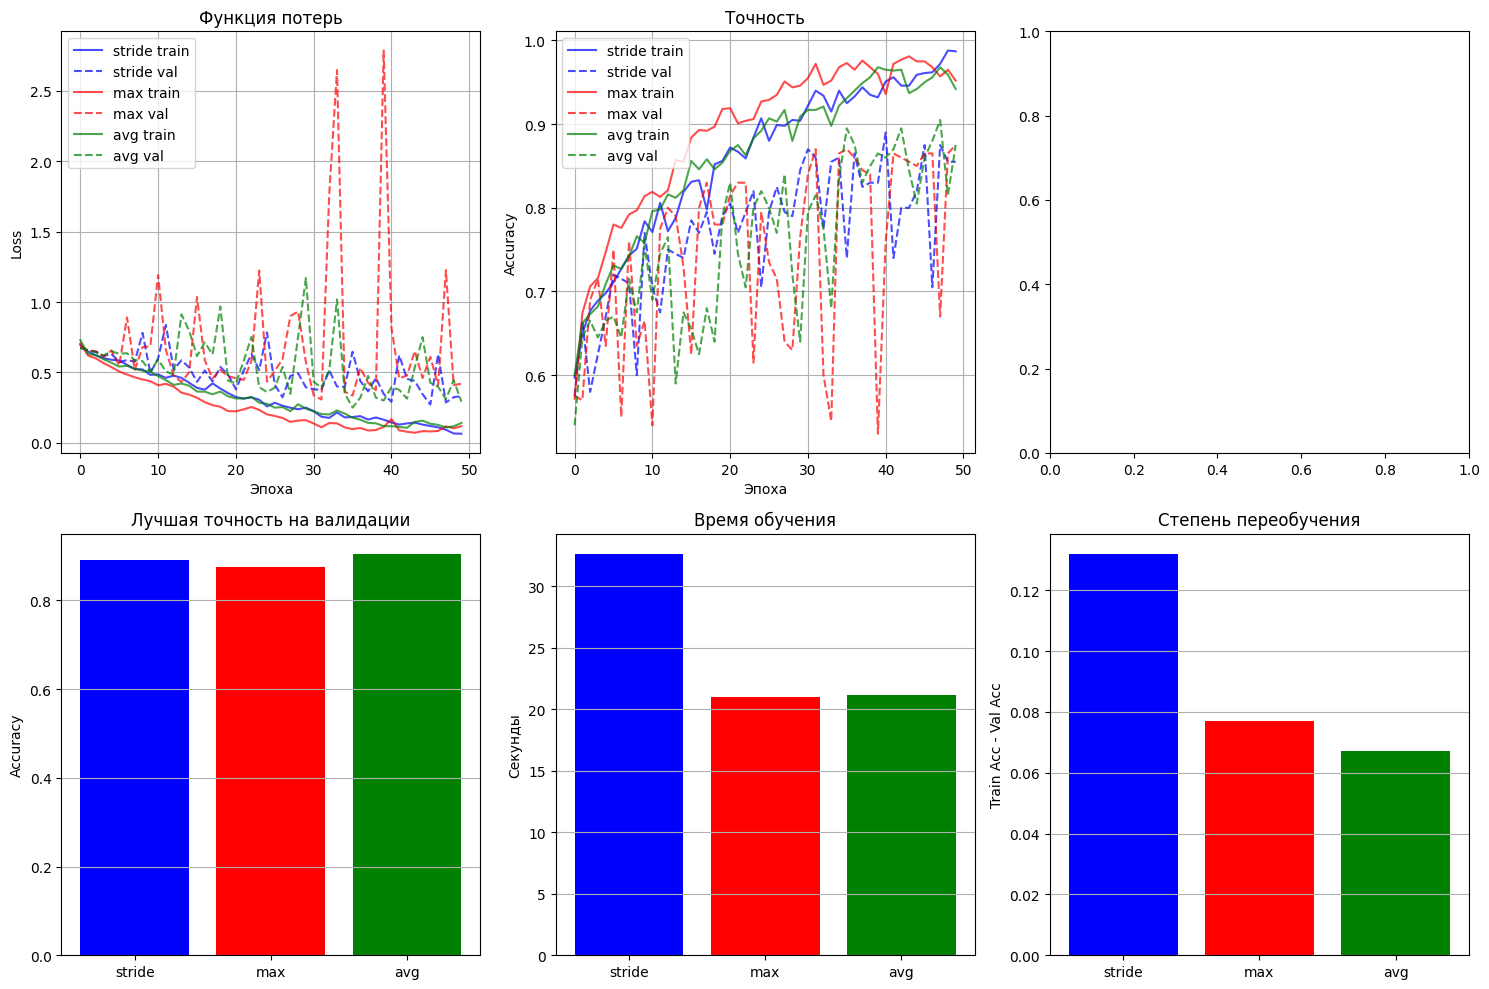

In [ ]:
print("\n" + "="*80)
print("СРАВНЕНИЕ РЕЗУЛЬТАТОВ ОБУЧЕНИЯ")
print("="*80)

# Создание графиков
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

colors = {'stride': 'blue', 'max': 'red', 'avg': 'green'}

for idx, pooling_type in enumerate(pooling_types):
    metrics = results[pooling_type]

    # График потерь
    axes[0, 0].plot(metrics['train_losses'], label=f'{pooling_type} train',
                    color=colors[pooling_type], linestyle='-', alpha=0.7)
    axes[0, 0].plot(metrics['val_losses'], label=f'{pooling_type} val',
                    color=colors[pooling_type], linestyle='--', alpha=0.7)

    # График точности
    axes[0, 1].plot(metrics['train_accs'], label=f'{pooling_type} train',
                    color=colors[pooling_type], linestyle='-', alpha=0.7)
    axes[0, 1].plot(metrics['val_accs'], label=f'{pooling_type} val',
                    color=colors[pooling_type], linestyle='--', alpha=0.7)

    # Вывод статистики
    print(f"\nПуллинг '{pooling_type}':")
    print(f"  Лучшая точность на валидации: {metrics['best_val_acc']:.4f}")
    print(f"  Время обучения: {training_times[pooling_type]:.2f} сек")

    # Расчет степени переобучения
    final_train_acc = metrics['train_accs'][-1]
    final_val_acc = metrics['val_accs'][-1]
    overfitting = final_train_acc - final_val_acc
    print(f"  Переобучение (train_acc - val_acc): {overfitting:.4f}")

# Настройка графиков
axes[0, 0].set_title('Функция потерь')
axes[0, 0].set_xlabel('Эпоха')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

axes[0, 1].set_title('Точность')
axes[0, 1].set_xlabel('Эпоха')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

# График сравнения лучших точностей
best_accs = [results[pt]['best_val_acc'] for pt in pooling_types]
axes[1, 0].bar(pooling_types, best_accs, color=[colors[pt] for pt in pooling_types])
axes[1, 0].set_title('Лучшая точность на валидации')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].grid(True, axis='y')

# График времени обучения
times = [training_times[pt] for pt in pooling_types]
axes[1, 1].bar(pooling_types, times, color=[colors[pt] for pt in pooling_types])
axes[1, 1].set_title('Время обучения')
axes[1, 1].set_ylabel('Секунды')
axes[1, 1].grid(True, axis='y')

# График переобучения
overfitting_vals = []
for pt in pooling_types:
    final_train_acc = results[pt]['train_accs'][-1]
    final_val_acc = results[pt]['val_accs'][-1]
    overfitting_vals.append(final_train_acc - final_val_acc)

axes[1, 2].bar(pooling_types, overfitting_vals, color=[colors[pt] for pt in pooling_types])
axes[1, 2].set_title('Степень переобучения')
axes[1, 2].set_ylabel('Train Acc - Val Acc')
axes[1, 2].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1, 2].grid(True, axis='y')

plt.tight_layout()
plt.show()


## ВЫБОР ЛУЧШЕЙ МОДЕЛИ

In [ ]:
best_pooling = max(results.keys(), key=lambda x: results[x]['best_val_acc'])
print(f"\n{'='*80}")
print(f"ЛУЧШАЯ МОДЕЛЬ: {best_pooling} пуллинг")
print(f"Точность: {results[best_pooling]['best_val_acc']:.4f}")
print(f"{'='*80}")

# Загрузка лучшей модели
checkpoint = torch.load(f'cifar100_model_{best_pooling}.pth')
best_model = Cifar100_CNN(
    hidden_size=checkpoint['model_params']['hidden_size'],
    num_classes=checkpoint['model_params']['num_classes'],
    pooling_type=checkpoint['model_params']['pooling_type']
)
best_model = nn.Sequential(
    Normalize(**checkpoint['normalize_params']),
    best_model
).to(device)
best_model.load_state_dict(checkpoint['model_state_dict'])
best_model.eval()

# Сохранение лучшей модели под общим именем
torch.save(checkpoint, 'best_cifar100_model.pth')
print("Лучшая модель сохранена как 'best_cifar100_model.pth'")


ЛУЧШАЯ МОДЕЛЬ: avg пуллинг
Точность: 0.9050
Лучшая модель сохранена как 'best_cifar100_model.pth'


## ОЦЕНКА ЛУЧШЕЙ МОДЕЛИ НА ТЕСТОВОЙ ВЫБОРКЕ

In [ ]:
print("\nОценка лучшей модели на тестовой выборке:")
best_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in dataloader['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = best_model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.argmax(dim=1).cpu().numpy())

print(classification_report(all_labels, all_preds,
                           target_names=[str(cls) for cls in CLASSES],
                           digits=4))


Оценка лучшей модели на тестовой выборке:
              precision    recall  f1-score   support

          22     0.9032    0.8400    0.8705       100
          11     0.8505    0.9100    0.8792       100

    accuracy                         0.8750       200
   macro avg     0.8768    0.8750    0.8748       200
weighted avg     0.8768    0.8750    0.8748       200



## ЭКСПОРТ В ONNX (ПОСЛЕ ПЕРЕЗАПУСКА СРЕДЫ)

In [ ]:
print("\n" + "="*80)
print("ЭКСПОРТ МОДЕЛИ В ONNX ФОРМАТ")
print("="*80)

# Загрузка модели (эмулируем перезапуск среды)
print("Загрузка сохраненной модели...")
checkpoint = torch.load('best_cifar100_model.pth', map_location=device)

# Создание модели с теми же параметрами
loaded_model = Cifar100_CNN(
    hidden_size=checkpoint['model_params']['hidden_size'],
    num_classes=checkpoint['model_params']['num_classes'],
    pooling_type=checkpoint['model_params']['pooling_type']
)

# Добавление слоя нормализации
loaded_model = nn.Sequential(
    Normalize(**checkpoint['normalize_params']),
    loaded_model
).to(device)

# Загрузка весов
loaded_model.load_state_dict(checkpoint['model_state_dict'])
loaded_model.eval()
print("Модель успешно загружена!")

# Подготовка примера входных данных
dummy_input = torch.randn(1, 32, 32, 3, device=device)  # NHWC формат

# Экспорт в ONNX
onnx_path = 'cifar100_model.onnx'
print(f"\nЭкспорт модели в ONNX: {onnx_path}")

torch.onnx.export(
    loaded_model,
    dummy_input,
    onnx_path,
    export_params=True,
    opset_version=11,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={
        'input': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    },
    verbose=True
)

print(f"Модель успешно экспортирована в ONNX формат!")
print(f"Размер файла: {os.path.getsize(onnx_path) / 1024:.2f} KB")


/tmp/ipython-input-3862240562.py:34: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(
W1225 21:09:57.827000 696 torch/onnx/_internal/exporter/_compat.py:114] Setting ONNX exporter to use operator set version 18 because the requested opset_version 11 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features



ЭКСПОРТ МОДЕЛИ В ONNX ФОРМАТ
Загрузка сохраненной модели...
Модель успешно загружена!

Экспорт модели в ONNX: cifar100_model.onnx
[torch.onnx] Obtain model graph for `Sequential([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `Sequential([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 127, in call
    converted_proto = _c_api_utils.call_onnx_api(
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/_c_api_utils.py", line 65, in call_onnx_api
    result = func(proto)
             ^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 122, in _partial_convert_version
    return onnx.version_converter.convert_version(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnx/version_converter.py", line 39, in convert_version
    converted_model_str = C.convert_version(model_str, target_version)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: /github/workspace/onnx/version_converter/adapters/axes_input_to_attribute.h:65: adapt: Asserti

[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 4 of general pattern rewrite rules.
Модель успешно экспортирована в ONNX формат!
Размер файла: 47.28 KB


## ПРОВЕРКА ONNX МОДЕЛИ

In [ ]:
try:
    import onnx
    import onnxruntime as ort

    # Проверка ONNX модели
    onnx_model = onnx.load(onnx_path)
    onnx.checker.check_model(onnx_model)
    print("\nONNX модель прошла проверку!")

    # Тестирование ONNX модели
    ort_session = ort.InferenceSession(onnx_path)

    # Подготовка входных данных
    test_input = np.random.randn(1, 32, 32, 3).astype(np.float32)

    # Запуск инференса
    ort_inputs = {ort_session.get_inputs()[0].name: test_input}
    ort_outs = ort_session.run(None, ort_inputs)

    print(f"Выход ONNX модели: shape={ort_outs[0].shape}")
    print("ONNX модель работает корректно!")

except ImportError:
    print("\nДля проверки ONNX модели установите: pip install onnx onnxruntime")
except Exception as e:
    print(f"\nОшибка при проверке ONNX модели: {e}")


ONNX модель прошла проверку!
Выход ONNX модели: shape=(1, 2)
ONNX модель работает корректно!


## СОХРАНЕНИЕ МОДЕЛИ НА ЛОКАЛЬНЫЙ ДИСК (ДЛЯ GOOGLE COLAB)

In [ ]:
from google.colab import files

# Скачивание файлов
files_to_download = [
    'best_cifar100_model.pth',
    'cifar100_model.onnx'
]

print("\nСкачивание файлов модели:")
for file in files_to_download:
    if os.path.exists(file):
        files.download(file)
        print(f"  {file}")
    else:
        print(f"  Файл {file} не найден")



Скачивание файлов модели:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  best_cifar100_model.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  cifar100_model.onnx
